## Level of sharing/concordance of caQTLS between the cell types in our study

- **Rev2.7**   *I was unsure of the level of concordance of cAQTL effects between the different major celltypes. Figure 2A illustrates overlap or not between major cell types. But this could be related to power, rather than true biological differences. Have the authors done an interaction analysis to identify caQTLs with evidence of cell type specific effects?*
 
The reviewer may refer to something similar as in the paper of Alasoo et al 2016 (Gaffney): In each condition, we first identified all genes and corresponding lead variants that displayed significant association at the 10% FDR level from RASQUAL. For each gene, we kept only independent lead variants (R2 <0.8). Finally, we used all independent pairs of genes and corresponding lead variants to test whether the eQTL effect size was significantly different among conditions. This procedure was equivalent to testing the significance of the interaction term between the condition and lead eQTL variant for each gene. 
Specifically ANOVA was used to compare two models for each gene-lead SNP pair:
- H0: expression~genotype+condition+covariates
- H1: expression~genotype+condition+genotype:condition+covariates
- P-values of rejecting H0 were calculated and BH correction performed to identify condition-specific QTLs


In [1]:
#library(qvalue)
library(repr)
library(pheatmap)
suppressPackageStartupMessages(library(DESeq2))
library(RColorBrewer)

In [2]:
suppressPackageStartupMessages(library(zoo))

In [3]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2/anova_interaction/')

In [4]:
ids = c(2:5, 8:10,12:14)

### Prepare data
Calculate LD in EUR  for all caQTL vars using plink (see command in the anova_interaction folder); make a matrix with peax x sample in each cell type combined together and normalize it using vst (alternatively try cqn package)

In [5]:
celltypes =  as.character(read.table("/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/color_scheme.tsv")[1:15,2])

In [6]:
celltypes

[1] "cMono"       "ncMono"      "iMono"       "cDC"         "mem_b"      
 [6] "naive_b"     "cyto_nk"     "adaptive_NK" "naive_cd8_t" "cyto_cd8_t" 
[11] "mem_cd8_t"   "naive_cd4_t" "act_cd4_t"   "tReg"        "mkc"

In [7]:
n = length(celltypes)

In [8]:
longf     = read.table('../summarized_caqtls/run3/EUR_caqtl_leads_run3.tsv', header=T)
genotypes = read.table("All_tested_genotypes.tsv", header=T)

In [10]:
longfsub = subset(longf, cell %in% celltypes & flag_fdr10==TRUE & exclude==FALSE)
#writeLines(gsub("chr","",as.character(unique(longfsub$varID))), "lead_caQTL_vars.txt")

In [11]:
for (ce in celltypes){
    mat = read.table(paste0("../rasqual_eur/fine/",ce, "/",ce, ".count_matrix"), header=TRUE, row.names=1)
    mat = mat[,6:ncol(mat)]
    colnames(mat) = paste0("PBMC",  ids, ".", ce)
    if(ce == celltypes[1]){
        counts = mat
    }else{
        if(sum(rownames(counts)!= rownames(mat))==0){
        counts = cbind(counts, mat)}
    }
}

In [12]:
vst_counts = vst(as.matrix(counts), blind=FALSE)

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



In [13]:
cov = read.table("sample_covariates.txt", header=T, check.names = F)

In [15]:
info = data.frame(celltype = rep(celltypes, each =10), sample_numb = rep( ids,n), 
                  samp_cell = paste(rep (rownames(cov),n), rep(celltypes, each =10) , sep="."),
                  sample_name = rep (rownames(cov),n), age = rep(cov$Age, n), sex = rep(cov$Sex,n),
                  coredata(cov[,3:6])[rep(seq(nrow(cov[,3:6])),n),]  )
                  

In [16]:
pca <- prcomp(t(vst_counts))
percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

In [17]:
colscheme = read.table("/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/color_scheme.tsv")

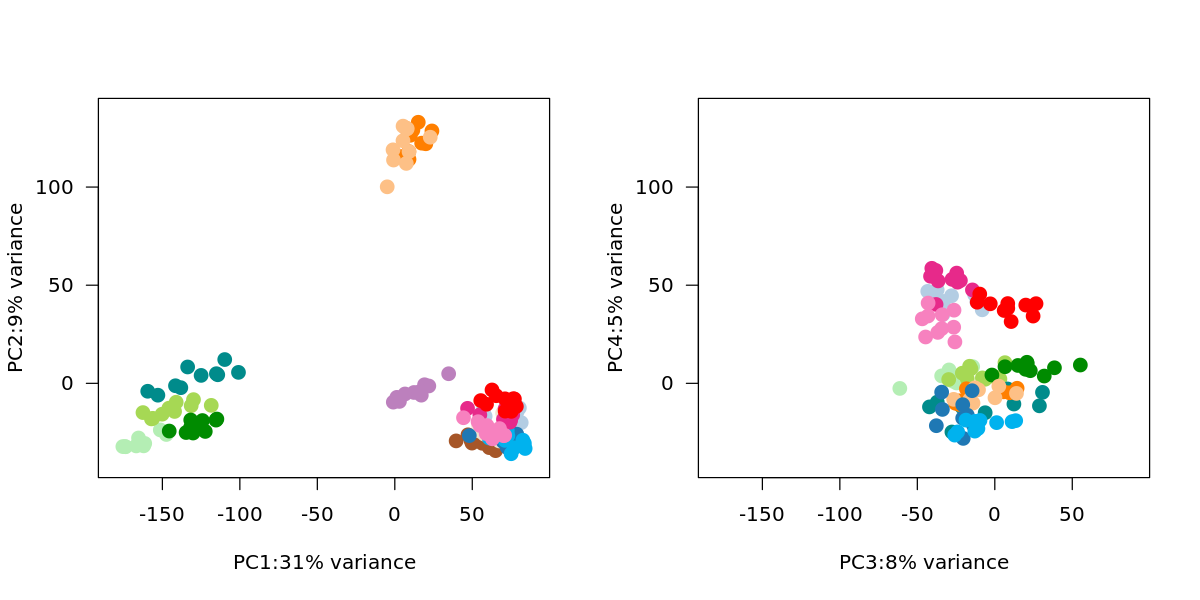

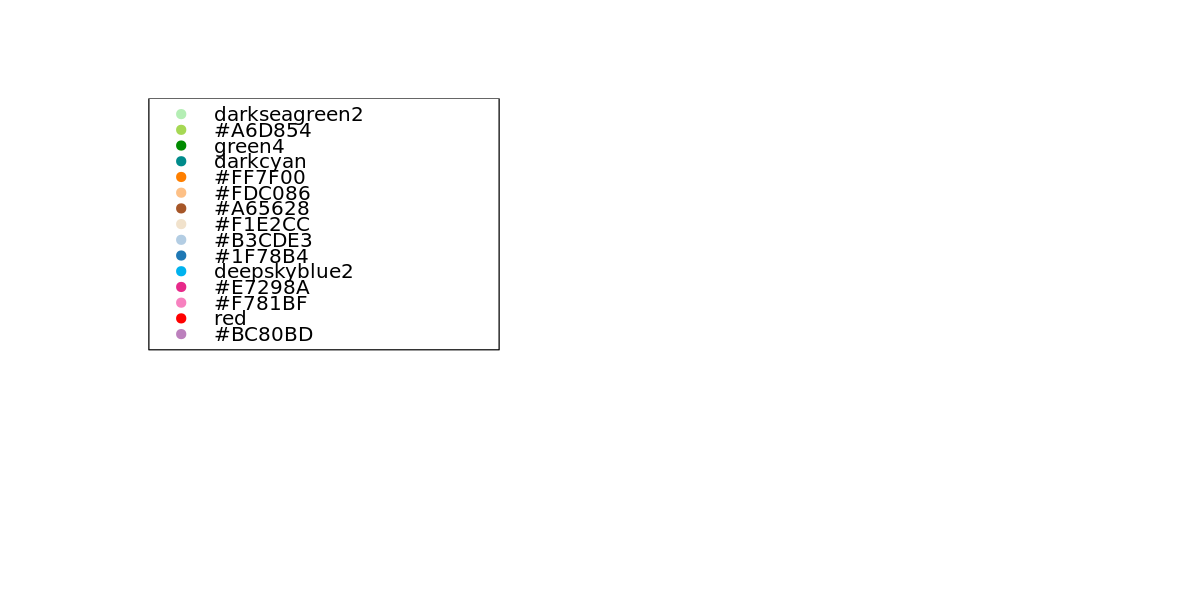

In [18]:
d <- data.frame(PC1=pca$x[,1], PC2=pca$x[,2] , PC3=pca$x[,3], PC4=pca$x[,4], info,
                Color = as.character(colscheme[1:15,1])[match(info$celltype,colscheme[1:15,2])])
                #Color = rainbow(5)[as.numeric(info$celltype)])
options(repr.plot.width=10, repr.plot.height=5)
par (mfrow=c(1,2))
plot(data=d, PC2~PC1,  xlab=(paste0("PC1:" ,round(percentVar[1] * 100),"% variance")),
       ylab=(paste0("PC2:",round(percentVar[2] * 100),"% variance")) , 
       pch= 19, 
      col = as.character(d$Color),  cex=1.5, las=1, xlim=c(min(d$PC1)-5, max(d$PC1)+5) , 
         ylim=c(min(d$PC2)-5, max(d$PC2)+5) )
plot(data=d, PC4~PC3,  xlab=(paste0("PC3:" ,round(percentVar[3] * 100),"% variance")),
       ylab=(paste0("PC4:",round(percentVar[4] * 100),"% variance")) , 
       pch= 19, 
      col = as.character(d$Color),  cex=1.5, las=1, xlim=c(min(d$PC1)-5, max(d$PC1)+5) , 
         ylim=c(min(d$PC2)-5, max(d$PC2)+5) )
plot.new()
legend("top", pch=19, col = as.character(colscheme[1:15,1]), legend = colscheme[1:15,1])

In [19]:
info = data.frame ( info, PC1=pca$x[,1], PC2=pca$x[,2] , PC3=pca$x[,3], PC4=pca$x[,4])

In [20]:
caQTL_counts = subset(vst_counts, rownames(vst_counts) %in% longfsub$Feature)

In [21]:
dim(caQTL_counts)

[1] 5272  150

In [22]:
longfsub = longfsub[order(longfsub$P_VAl),]

In [23]:
longfs2 = subset(longfsub, !duplicated(longfsub[,c('varID', "Feature")]))

In [35]:
longfs2 = longfs2[order(longfs2$P_VAl),]

In [26]:
longfs2$feature_snp = paste( longfs2$Feature, longfs2$varID, sep=";")

In [97]:
#peaksnps_tests = longfs2[!duplicated(longfs2$Feature), c("Feature", "varID")]
peaksnps_tests = droplevels(subset(longfs2, feature_snp %in% feat_snp | Feature %in% ag$Feature [ag$varID==1]))

In [98]:
peaksnps_tests = peaksnps_tests[, c("Feature", "varID")]

In [100]:
dim(peaksnps_tests) ###independent snps

[1] 6279    2

In [161]:
dim(longfs2) #### all unique qtlpeak- leadsnp

[1] 6531   32

Just test all of the variants and then pick the best q value? most of them there is only one lead anyway

### Perform Test

In [28]:
peaksnps_tests = longfs2

In [29]:
covariate_names = c("age", "sex", "GT1","GT2","GT3","GT4", "PC1","PC2","PC3","PC4")

qtl_formula = as.formula(paste("expression ~ genotype + celltype ", 
                               paste(covariate_names, collapse = " + "), sep = "+ "))
interaction_formula = as.formula(paste("expression ~ genotype + celltype + celltype:genotype ", 
                                       paste(covariate_names, collapse = " + "), sep = "+ "))

In [30]:
qtl_formula

expression ~ genotype + celltype + age + sex + GT1 + GT2 + GT3 + 
    GT4 + PC1 + PC2 + PC3 + PC4

In [31]:
### which is this missing from all genotypes???
peaksnps_tests[!(peaksnps_tests$varID %in% rownames(genotypes)),]

,Feature,varID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,Convergence_status,r2_fSNPs,r2_rSNP,P_VAl,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,rsID
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>
729627,chr13:97049931-97050535,chr13:97050323:A:G,chr13,97050323,A,G,0.35,1.160488,0.991031,-3.252439,⋯,0,0.984581,0.988832,0.0005399348,TRUE,TRUE,TRUE,mkc,FALSE,rs4771942


In [32]:
peaksnps_tests = subset(peaksnps_tests,varID %in% rownames(genotypes))

In [33]:
result_complete = list()
results_pvals = vector(mode = "numeric",length = nrow(peaksnps_tests))
  for(i in 1:nrow(peaksnps_tests)){

    gene_id = as.character(peaksnps_tests[i,]$Feature)
    snp_id  = as.character(peaksnps_tests[i,]$varID)


sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),length(celltypes)))      
      
no_interaction = lm(qtl_formula, as.data.frame(sample_data))
interaction    = lm(interaction_formula, as.data.frame(sample_data))
res            = anova(no_interaction, interaction)
      results_pvals [i] = res[2,6]
      
      test = list(anova = res, qtl_model = no_interaction, interaction_model = interaction)
      result_complete[[paste(gene_id,snp_id, sep = ";")]] = test
  }

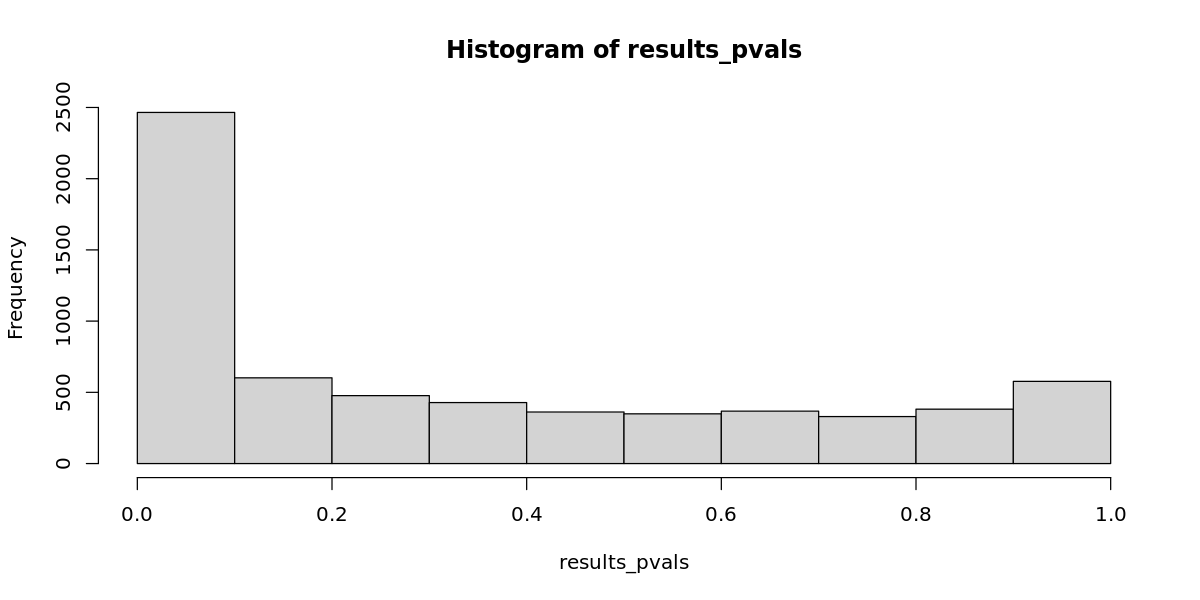

In [34]:
hist (results_pvals)

In [35]:
peaksnps_tests$aov_pval = results_pvals
peaksnps_tests$aov_qval = p.adjust(results_pvals)

In [36]:
peaksnps_tests= peaksnps_tests[order(peaksnps_tests$aov_pval),]

In [37]:
#unisnps = longfs2[!duplicated(longfs2$varID),]

In [38]:
#peaksnps_tests$rsID = unisnps$rsID[match(peaksnps_tests$varID,unisnps$varID)]

In [39]:
sum(is.na(peaksnps_tests$aov_qval))

[1] 1

In [40]:
sum(peaksnps_tests$aov_qval<0.1, na.rm=T)

[1] 395

In [41]:
length(unique(peaksnps_tests$Feature[peaksnps_tests$aov_qval<0.1]))

[1] 340

In [42]:
dim(peaksnps_tests)

[1] 6341   34

In [43]:
length(unique(peaksnps_tests$Feature))

[1] 5271

- 398 out of 6365 caQTLs pair (peak-snp ) seems significantly cell-type specific/ with different effect sizes
- 342 out of 5286 caQTLs peaks seems significantly cell-type specific/ with different effect sizes

In [44]:
342/5287

[1] 0.06468697

In [45]:
peaksnps_testsuni = peaksnps_tests[!duplicated(peaksnps_tests$Feature),]

In [46]:
longf = subset(longf , cell %in% celltypes)
agg = aggregate(cell~Feature, longf, length)

In [47]:
priv = as.character(unique(agg$Feature[agg$cell==1]))

In [48]:
table(peaksnps_testsuni$Feature %in% priv, peaksnps_testsuni$aov_qval<0.1)

       
        FALSE TRUE
  FALSE  4132  255
  TRUE    799   84

In [49]:
sub = subset(peaksnps_testsuni, Feature %in% priv & aov_qval<0.1)

In [50]:
sub = subset(sub, cell == 'cMono')

In [51]:
sub2 = subset(peaksnps_testsuni, Feature %in% priv & cell != 'cMono'& aov_qval>0.1)

In [52]:
longfsub = subset(longfsub , cell %in% celltypes)
aggs = aggregate(cell~Feature, longfsub, length)
privsig = as.character(unique(aggs$Feature[aggs$cell==1]))

In [54]:
strongpeaks = rownames(caQTL_counts)[rowMeans(caQTL_counts)>4]

In [55]:
sub3 = subset(peaksnps_testsuni, Feature %in% privsig  & aov_qval<0.05 & Feature %in% strongpeaks)

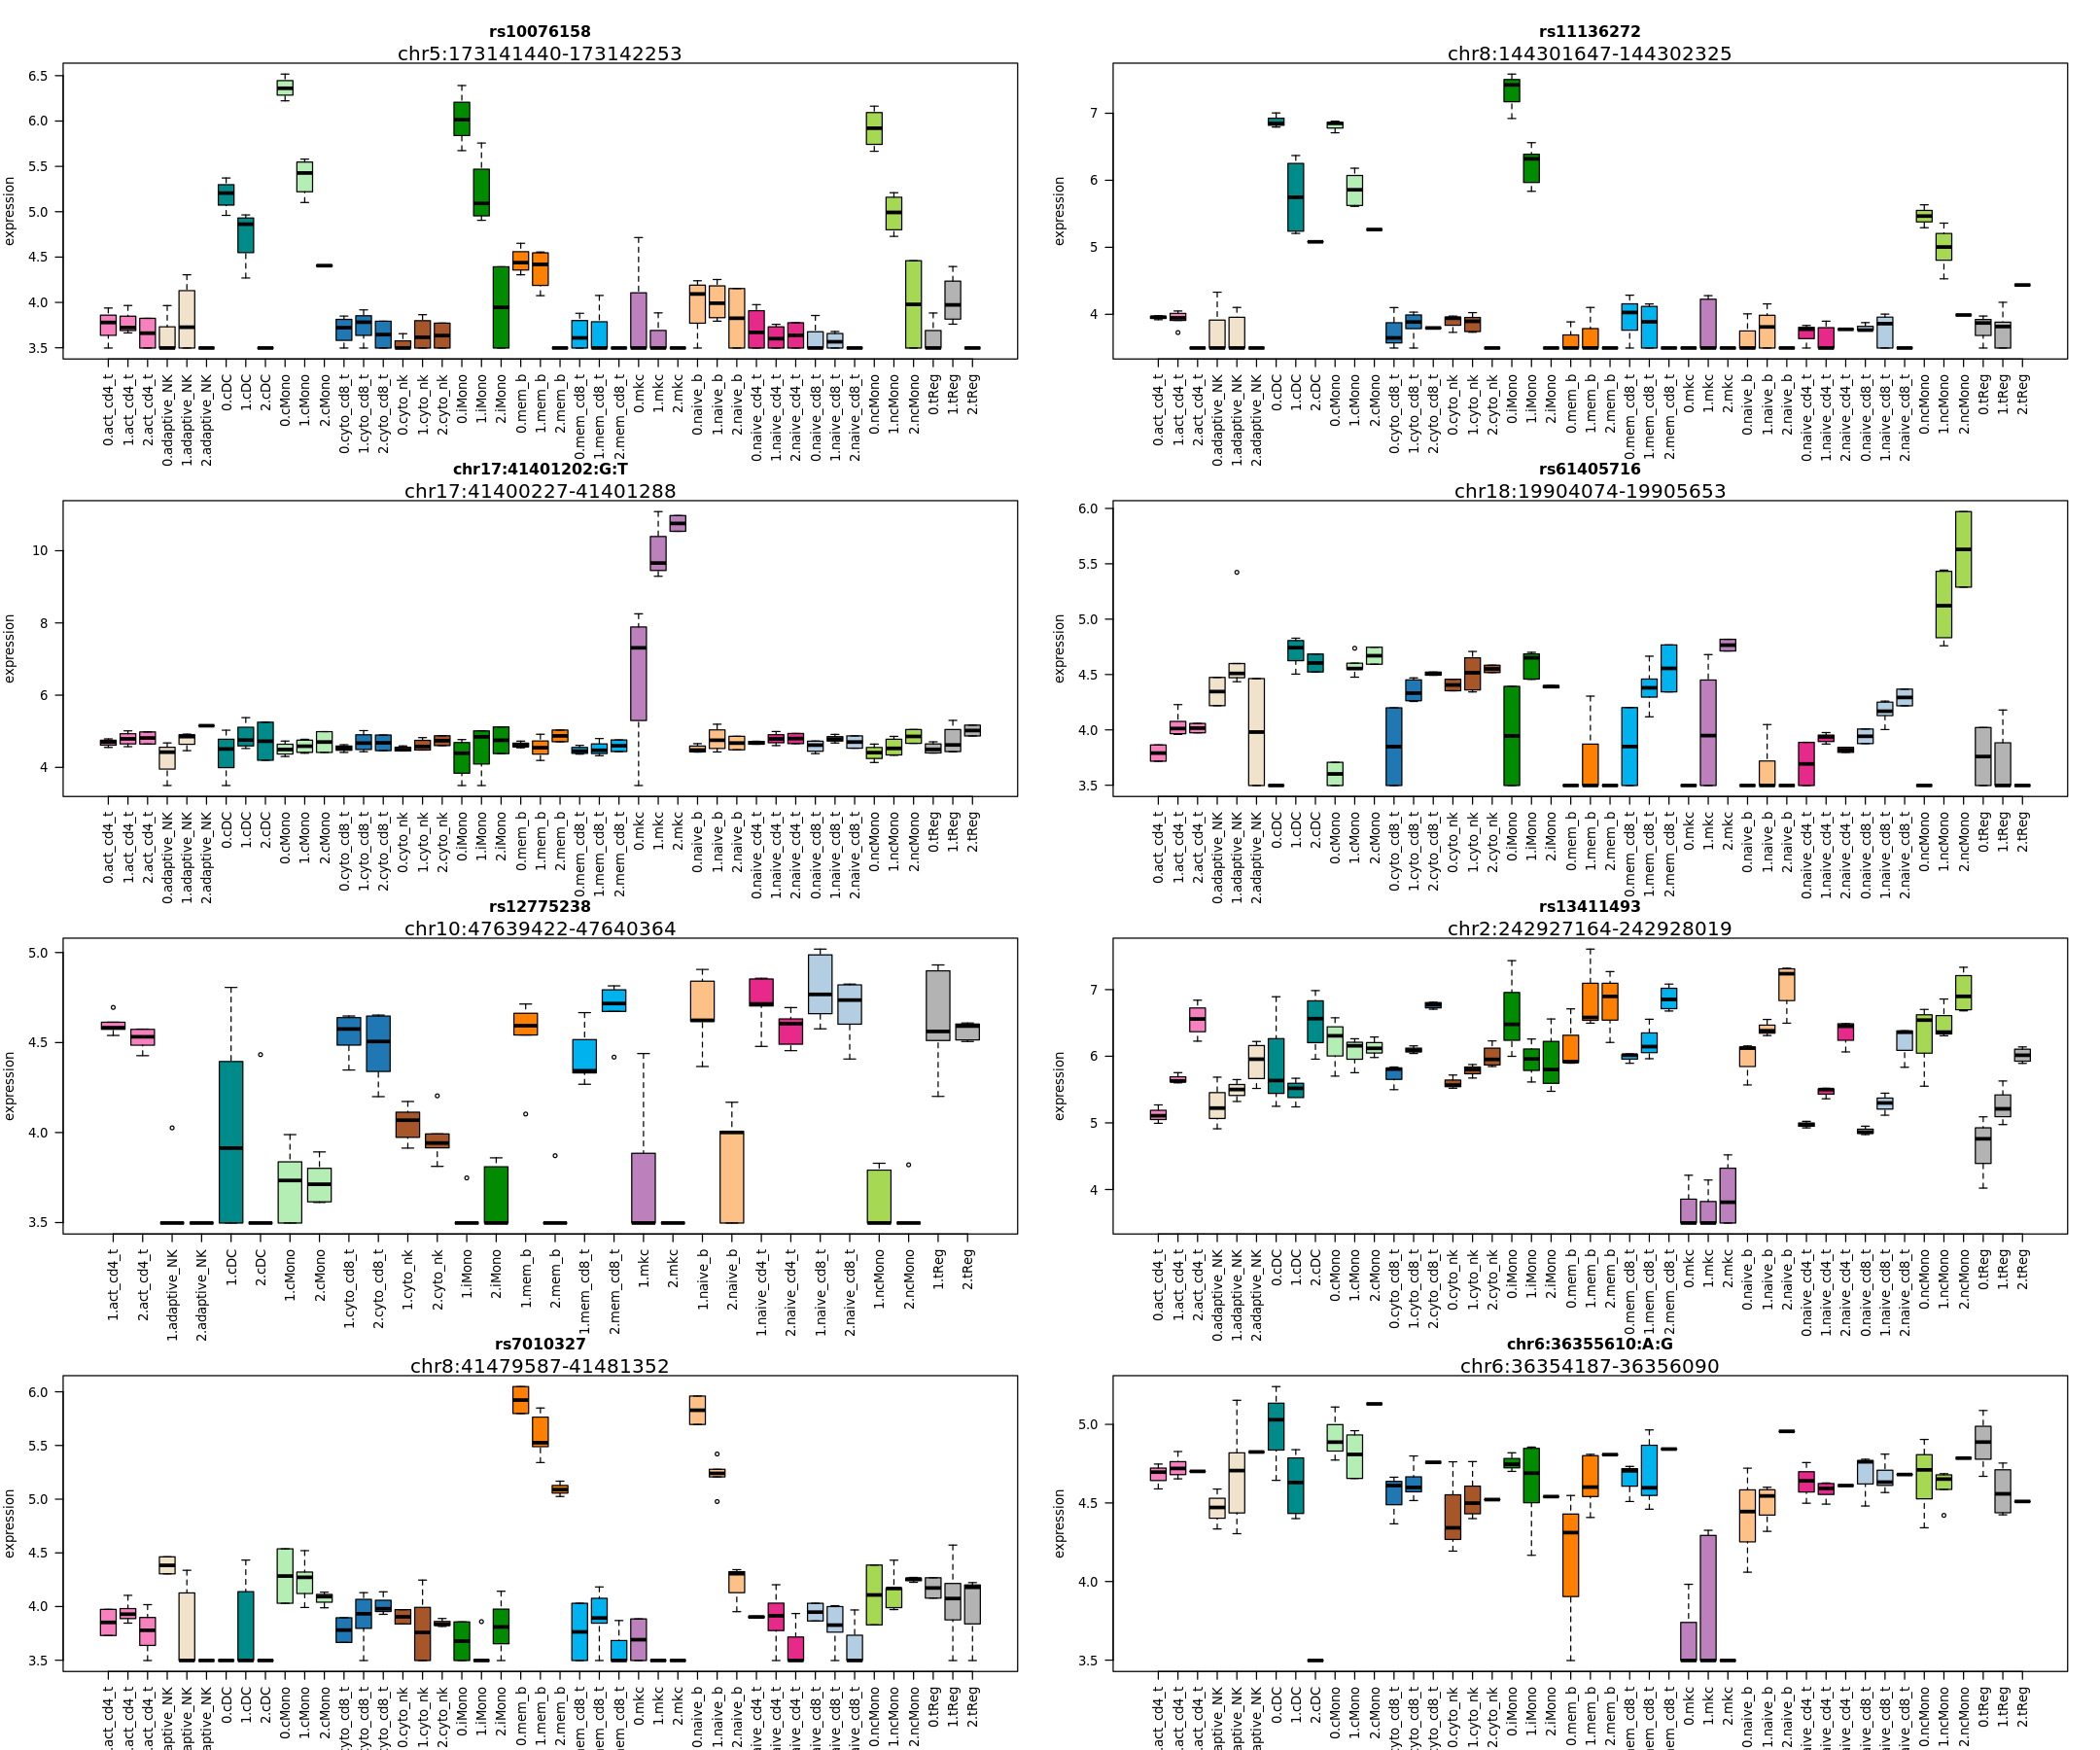

In [56]:
options(repr.plot.width=18, repr.plot.height=15)
par(mfrow=c(4,2))
for(i in 1:8){

    gene_id = as.character(sub3[i,]$Feature)
    snp_id  = as.character(sub3[i,]$varID)
    rsid    = sub3$rsID[i]
sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),n))      

boxplot(expression~genotype+celltype,sample_data, las=2, 
        col = rep(as.character(colscheme[order(colscheme$V2),1]),each=length(unique(sample_data$genotype))), 
        xlab=NA, main=rsid)
mtext(gene_id)
      }

In [57]:
peaksnps_tests[peaksnps_tests$Feature=="chr5:54048694-54049421",]

,Feature,varID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,r2_rSNP,P_VAl,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,rsID,aov_pval,aov_qval
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<dbl>,<dbl>
427032,chr5:54048694-54049421,chr5:54048987:G:A,chr5,54048987,G,A,0.45,1.551882,0.996360,-2.197919,⋯,0.994894,0.001786218,TRUE,TRUE,FALSE,cMono,FALSE,rs1445839,1.604172e-09,1.00357e-05
323143,chr5:54048694-54049421,chr5:54048853:T:G,chr5,54048853,T,G,0.45,1.551882,0.999945,-2.046048,⋯,0.995410,0.002950642,TRUE,TRUE,FALSE,act_cd4_t,FALSE,rs1445837,1.604172e-09,1.00357e-05
741708,chr5:54048694-54049421,chr5:54039907:G:A,chr5,54039907,G,A,0.35,1.160488,0.996255,-1.853859,⋯,0.991726,0.004666804,TRUE,TRUE,FALSE,naive_b,FALSE,rs9292069,2.478081e-06,1.50147e-02


In [58]:
examples = c("rs61943586","rs13294415","rs11136478","rs10888395","rs1475159",'rs1867687')

In [59]:
snps_pos =sapply(examples, function(y) which(peaksnps_tests$rsID==y) )

In [60]:
snps_pos

$rs61943586
[1] 2870

$rs13294415
integer(0)

$rs11136478
integer(0)

$rs10888395
[1] 1496

$rs1475159
[1] 1301

$rs1867687
integer(0)

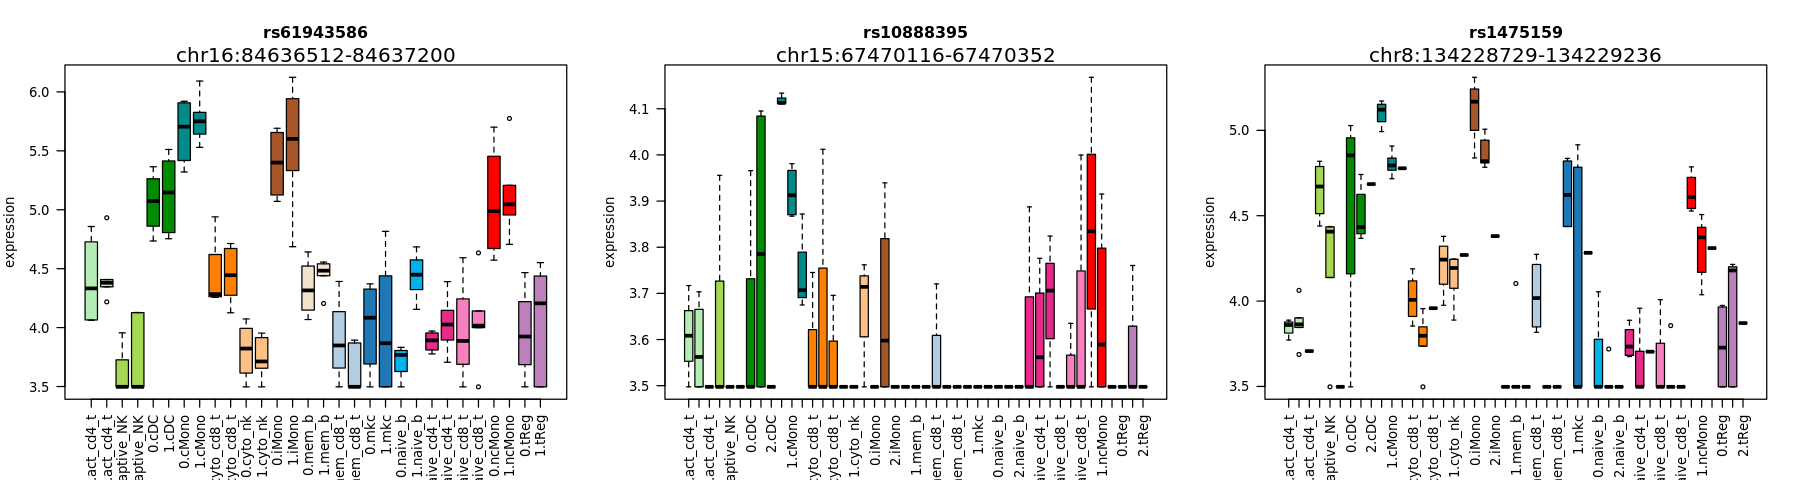

In [61]:
options(repr.plot.width=15, repr.plot.height=4)
par(mfrow=c(1,3))
for(i in na.omit(unlist(snps_pos))){
    gene_id = as.character(peaksnps_testsuni[i,]$Feature)
    snp_id  = as.character(peaksnps_testsuni[i,]$varID)
sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),n))      

boxplot(expression~genotype+celltype,sample_data, las=2, 
        col = rep(as.character(colscheme[1:15,1]),each=length(unique(sample_data$genotype))), 
        xlab=NA, main=peaksnps_tests$rsID[i])
mtext(gene_id)
      }

In [62]:
peaksnps_tests$private = peaksnps_tests$Feature %in% priv

In [63]:
longfs = subset(longf, flag_fdr10==T & exclude==F)

agg2 = aggregate(cell~Feature, longfs, length)

privs = as.character(unique(agg2$Feature[agg2$cell==1]))

peaksnps_tests$exclusive = peaksnps_tests$Feature %in% privs

In [64]:
peaksnps_tests = merge(peaksnps_tests, agg, by="Feature")

colnames(peaksnps_tests)[ncol(peaksnps_tests)] = "n_tested_cells"

peaksnps_tests = merge(peaksnps_tests, agg2, by="Feature")

colnames(peaksnps_tests)[ncol(peaksnps_tests)] = "n_significant_cells"

In [65]:
peaksnps_tests = peaksnps_tests[order(peaksnps_tests$aov_pval),]
peaksnps_tests_uni = peaksnps_tests[!duplicated(peaksnps_tests$Feature),]

In [66]:
tb1 = table(peaksnps_tests_uni$n_tested_cells==1, peaksnps_tests_uni$aov_qval<0.1)

In [67]:
fisher.test(table(peaksnps_tests$n_tested_cells==1, peaksnps_tests$aov_qval<0.1))


	Fisher's Exact Test for Count Data

data:  table(peaksnps_tests$n_tested_cells == 1, peaksnps_tests$aov_qval < 0.1)
p-value = 4.511e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.334711 2.247701
sample estimates:
odds ratio 
  1.739388 


In [68]:
getwd()

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/anova_interaction"

In [69]:
write.csv(peaksnps_tests, "results_anova_fine.csv")

In [70]:
broad = read.csv("results_anova_broad.csv", row.names=1)

In [71]:
broad = broad[order(broad$aov_pval),]
peaksnps_tests_unibr = broad[!duplicated(broad$Feature),]

In [72]:
tb2 = table(peaksnps_tests_unibr$n_tested_cells==1, peaksnps_tests_unibr$aov_qval<0.1)

In [73]:
tb1

       
        FALSE TRUE
  FALSE  4132  255
  TRUE    799   84

In [1]:
255+84

[1] 339

In [2]:
66+56

[1] 122

In [4]:
799+84

[1] 883

In [195]:
770+77

[1] 847

In [75]:
tb2

       
        FALSE TRUE
  FALSE  3894   66
  TRUE   1891   56

In [3]:
1891  +56

[1] 1947

In [177]:
1817  +49

[1] 1866

In [77]:
fisher.test(tb2)


	Fisher's Exact Test for Count Data

data:  tb2
p-value = 0.003317
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.196008 2.544408
sample estimates:
odds ratio 
  1.747095 


In [78]:
pdf("../figures/Pie_classification_qtls.pdf")
par(mfrow=c(2,2))
col= rev(brewer.pal(4,"PRGn"))[3:4]
pie(tb1, col=col, labels = tb1, main = "Cell subtypes")
pie(tb1, col="white",density=c(0,0,20,20) ,angle = 30)

pie(tb2, col=col, labels = tb2, main = "Cell types")
pie(tb2, col="white",density=c(0,0,20,20) ,angle = 30)
#plot.new()
legend("center", pt.bg=col, pch=22, legend = 1:4, bty='n', pt.cex=3)
dev.off()

png 
  2

In [79]:
pdf("../figures/Pie_classification_qtlslegend.pdf")
par(mfrow=c(2,2))
plot.new()
legend("center", pt.bg=col, pch=22, legend = 1:4, bty='n', pt.cex=3)
plot.new()
legend("center", density=30, col="white", pch=22, legend = 1:4, bty='n')

dev.off()

png 
  2

In [80]:
head(longf)

,Feature,varID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,Convergence_status,r2_fSNPs,r2_rSNP,P_VAl,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,rsID
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>
322539,chr10:51502604-51504683,chr10:51503178:G:A,chr10,51503178,G,A,0.45,1.715131,0.991469,-19.52688,⋯,0,0.965503,0.979683,2.632664e-20,TRUE,TRUE,TRUE,act_cd4_t,FALSE,rs2611475
322540,chr6:32635924-32636583,chr6:32636376:C:G,chr6,32636376,C,G,0.45,0.001020,0.995562,-16.97326,⋯,0,0.991991,0.991873,1.802573e-19,TRUE,TRUE,TRUE,act_cd4_t,FALSE,rs2856698
322541,chr10:27546208-27546939,chr10:27546467:G:C,chr10,27546467,G,C,0.25,1.111111,0.990104,-14.15310,⋯,0,0.951346,0.978134,2.454829e-15,TRUE,TRUE,TRUE,act_cd4_t,FALSE,rs2488369
322542,chr6:43737236-43739826,chr6:43737873:G:A,chr6,43737873,G,A,0.10,0.123457,0.994865,-11.97900,⋯,0,0.991476,0.983246,9.541214e-14,TRUE,TRUE,TRUE,act_cd4_t,FALSE,chr6:43737873:G:A
322543,chr6:166672201-166673529,chr6:166672298:G:A,chr6,166672298,G,A,0.40,0.277778,0.989443,-11.39206,⋯,0,0.983409,0.982888,1.928802e-12,TRUE,TRUE,TRUE,act_cd4_t,FALSE,rs911202
322544,chr7:134831931-134833621,chr7:134833233:G:A,chr7,134833233,G,A,0.60,4.444444,0.998298,-10.56247,⋯,0,0.987382,0.981880,2.272994e-11,TRUE,TRUE,TRUE,act_cd4_t,FALSE,rs3735000


In [215]:
subset(longf, rsID=='rs1867687', select=c('cell', 'Effect_size', "flag_fdr10", "rsID", "Feature" ))

,cell,Effect_size,flag_fdr10,rsID,Feature
,<chr>,<dbl>,<lgl>,<chr>,<chr>
46129,mono,0.624291,TRUE,rs1867687,chr5:54048694-54049421


In [184]:
dim(longf)

[1] 1133379      32

In [221]:
bul = read.table("../summarized_caqtls/run3/nk_caqtl_sumstats_run3.tsv", header=T)

In [222]:
subset(bul, rsID=='rs1867687', select=c( 'Effect_size', "Q_value", "rsID", "Feature" ))

,Effect_size,Q_value,rsID,Feature
,<dbl>,<dbl>,<chr>,<chr>
181970,0.457500,0.4010182,rs1867687,chr5:54039841-54041129
181981,0.307320,0.1580219,rs1867687,chr5:54048694-54049421
181987,0.413177,0.4224603,rs1867687,chr5:54052155-54052712
181993,0.487471,0.8472820,rs1867687,chr5:54056333-54057137
